In [1]:
# Dependencies
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from math import sqrt

In [2]:
# Read Housing Price Training Data
training_df = pd.read_csv("MLResources/realestate_all_train.csv")
training_df.head()
training_df.count()

County    1188
State     1188
Year      1188
Price     1143
dtype: int64

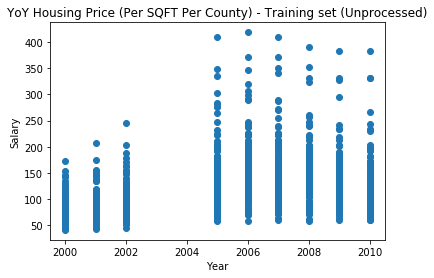

In [3]:
# Plot Training Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Training set (Unprocessed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [4]:
# plt.hist(training_df['Price'], 2000)
# plt.show()

In [5]:
# Handle missing data
missing_df = training_df.loc[training_df['Year'].isin(['2003','2004'])]
missing_df.head()  

,County,State,Year,Price


In [6]:
# Backfill missing data for 2003 and 2004 from 2002 and 2005 
backfill_2002_df = training_df.loc[training_df['Year'].isin(['2002'])]
backfill_2005_df = training_df.loc[training_df['Year'].isin(['2005'])]
backfill_2002_df = backfill_2002_df.dropna()
backfill_2005_df = backfill_2005_df.dropna()
backfill_2002_df.count()
backfill_2005_df.count()

County    128
State     128
Year      128
Price     128
dtype: int64

In [7]:
backfill_df = backfill_2002_df.merge(backfill_2005_df, on=['County','State'], how='inner')
backfill_df.head()
# backfill_df.count()

,County,State,Year_x,Price_x,Year_y,Price_y
0,King County,WA,2002,154.750000,2005,202.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000
2,Montgomery County,MD,2002,170.083333,2005,282.000000
3,Prince Georges County,MD,2002,108.583333,2005,194.166667
4,Baltimore County,MD,2002,99.250000,2005,163.666667


In [8]:
backfill_df['Diff_Price'] = backfill_df['Price_y'] - backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667


In [9]:
backfill_df['2003_Price'] = backfill_df['Diff_Price']/3 + backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222


In [10]:
backfill_df['2004_Price'] = backfill_df['Price_y'] - backfill_df['Diff_Price']/3 
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price,2004_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000,186.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222,261.361111
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889,244.694444
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111,165.638889
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222,142.194444


In [11]:
backfill_2003 = backfill_df.loc[:, ['County','State','Year','2003_Price']]
backfill_2003['Year'] = 2003
backfill_2003 = backfill_2003.rename(columns = {'2003_Price': 'Price'})
backfill_2003.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,County,State,Year,Price
0,King County,WA,2003,170.750000
1,Fairfax County,VA,2003,219.972222
2,Montgomery County,MD,2003,207.388889
3,Prince Georges County,MD,2003,137.111111
4,Baltimore County,MD,2003,120.722222


In [12]:
backfill_2004 = backfill_df.loc[:, ['County','State','Year','2004_Price']]
backfill_2004['Year'] = 2004
backfill_2004 = backfill_2004.rename(columns = {'2004_Price': 'Price'})
backfill_2004.head()

,County,State,Year,Price
0,King County,WA,2004,186.750000
1,Fairfax County,VA,2004,261.361111
2,Montgomery County,MD,2004,244.694444
3,Prince Georges County,MD,2004,165.638889
4,Baltimore County,MD,2004,142.194444


In [13]:
training_df = training_df.append(backfill_2003, ignore_index=True)
training_df = training_df.append(backfill_2004, ignore_index=True)
training_df.head()

,County,State,Year,Price
0,King County,WA,2000,141.166667
1,Fairfax County,VA,2000,134.000000
2,Montgomery County,MD,2000,126.916667
3,Prince Georges County,MD,2000,91.833333
4,Baltimore County,MD,2000,86.750000


In [14]:
print(training_df.loc[training_df['Price'].isin(['NaN'])].count())

County    45
State     45
Year      45
Price      0
dtype: int64


In [15]:
training_dfdum = training_df.dropna()
training_dfdum.head()
training_dfdum.count()

County    1391
State     1391
Year      1391
Price     1391
dtype: int64

In [16]:
print(training_dfdum.loc[training_dfdum['Price'].isin(['NaN'])])

Empty DataFrame
Columns: [County, State, Year, Price]
Index: []


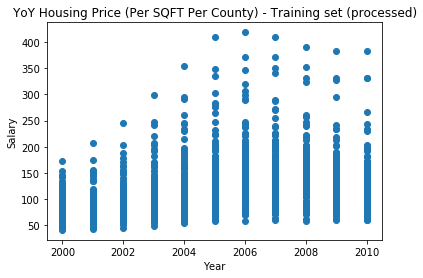

In [17]:
# Plot Training Data After Handling Missig Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Training set (processed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [22]:
for county in training_df['County'].unique():
    print(training_df.loc[training_df['County'].isin([county])])

           County State  Year       Price
0     King County    WA  2000  141.166667
132   King County    WA  2001  148.416667
264   King County    WA  2002  154.750000
396   King County    WA  2005  202.750000
528   King County    WA  2006  237.250000
660   King County    WA  2007  254.416667
792   King County    WA  2008  240.333333
924   King County    WA  2009  213.166667
1056  King County    WA  2010  198.416667
1188  King County    WA  2003  170.750000
1312  King County    WA  2004  186.750000
              County State  Year       Price
1     Fairfax County    VA  2000  134.000000
133   Fairfax County    VA  2001  156.416667
265   Fairfax County    VA  2002  178.583333
397   Fairfax County    VA  2005  302.750000
529   Fairfax County    VA  2006  306.916667
661   Fairfax County    VA  2007  287.666667
793   Fairfax County    VA  2008  257.583333
925   Fairfax County    VA  2009  240.666667
1057  Fairfax County    VA  2010  243.666667
1189  Fairfax County    VA  2003  219.972222
1

1390  Talbot County    MD  2004  146.416667
             County State  Year       Price
81    Warren County    VA  2000   92.666667
213   Warren County    VA  2001   95.166667
345   Warren County    VA  2002  107.083333
477   Warren County    VA  2005  171.166667
609   Warren County    VA  2006  185.500000
741   Warren County    VA  2007  177.166667
873   Warren County    VA  2008  155.083333
1005  Warren County    VA  2009  137.000000
1137  Warren County    VA  2010  130.750000
1267  Warren County    VA  2003  128.444444
1391  Warren County    VA  2004  149.805556
                 County State  Year       Price
82    Gloucester County    VA  2000   74.416667
214   Gloucester County    VA  2001   78.833333
346   Gloucester County    VA  2002   82.583333
478   Gloucester County    VA  2005  119.166667
610   Gloucester County    VA  2006  139.083333
742   Gloucester County    VA  2007  144.333333
874   Gloucester County    VA  2008  135.166667
1006  Gloucester County    VA  2009  130.750

In [ ]:
cat_features = ['County','State']
num_features = ['Price','Year']

categories = cat_features[0:len(cat_features)]

In [ ]:
for category in categories:
    series = training_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    training_dfdum = pd.concat([training_dfdum, dummies], axis=1)
    
print(training_dfdum.columns)
training_dfdum.head(20)

In [ ]:
training_dfdum['County'].unique()

In [21]:
# from sklearn.preprocessing import Imputer
# imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# imputer = imputer.fit(X_train[:, 1:3])
# X_train[:, 1:3] = imputer.transform(X_train[:, 1:3])

In [ ]:
train_coefficients = []
train_intercepts = []

regr = linear_model.LinearRegression()

for county in training_dfdum['County'].unique():
    
    if county != 'Alleghany County' and county != 'Manassas Park City' and county != 'Ferry County':
        
        X_train = training_dfdum.loc[training_dfdum['County'].isin([county]), ['Year','County_'+county]]
                
#         X_train = np.asarray(X_train.values)
#         X_train = X_train.reshape(-1, 1)

        y_train = training_dfdum.loc[training_dfdum['County'].isin([county]), 'Price']
#         y_train = np.asarray(y_train.values)
#         y_train = y_train.reshape(-1, 1)

        lr_model = regr.fit(X_train, y_train)

        train_coefficients.append(lr_model.coef_) 
        train_intercepts.append(lr_model.intercept_)

    #     print('Weight coefficients: ', lr_model.coef_)
    #     print('y-axis intercept: ', lr_model.intercept_) 

    #     plt.scatter(X_train, y_train)
    #     plt.show()

        print('County:{0}'.format(county))
        print('X_train:{0}'.format(X_train))
        print('y_train:{0}'.format(y_train))

# print(train_coefficients)

# print(train_intercepts)


# mx + b = y




In [ ]:
y_train_predict = lr_model.predict(X_train)
print(f"True output: {y_train}")
print(f"Predicted output: {y_train_predict[0]}")
print(f"Prediction Error: {y_train_predict[0]-y_train[0]}")

# plt.scatter(X_train, y_train_predict)

In [ ]:
lr_r2 =  r2_score(y_train, y_train_predict)

In [ ]:
bx=plt.subplots(figsize=(12,8))
bx= sns.barplot(x=0, y=1, data=pd.DataFrame(zip(X_train, lr_model.coef_)))
plt.xticks(rotation='vertical')
plt.xlabel("Model Coefficient Types")
plt.ylabel("Model Coefficient Values")
plt.show()
print ("R squared: ", lr_r2)
print ("Average Coefficients: ", abs(lr_model.coef_).mean())
print ("Root Mean Squared Error: ", sqrt(mean_squared_error(y_train, y_train_predict)))
ax = sns.regplot(y_train, y_train_predict)

In [ ]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_predict)
# test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
# print('The test accuracy is', test_accuracy)

In [18]:
# # Handle missing data
# missing_df = training_df.loc[training_df['Year'].isin(['2003','2004'])]
# missing_df.head()  # Backfill missing data for 2003 and 2004 from 2002 and 2005 
# backfill_2002_df = training_df.loc[training_df['Year'].isin(['2002'])]
# backfill_2005_df = training_df.loc[training_df['Year'].isin(['2005'])]
# backfill_2002_df = backfill_2002_df.dropna()
# backfill_2005_df = backfill_2005_df.dropna()
# backfill_2002_df.count()
# backfill_2005_df.count()

# backfill_df = backfill_2002_df.merge(backfill_2005_df, on=['County','State'], how='inner')
# backfill_df.head()
# # backfill_df.count()

# backfill_df['Diff_Price'] = backfill_df['Price_y'] - backfill_df['Price_x']
# backfill_df.head()

# backfill_df['2003_Price'] = backfill_df['Diff_Price']/3 + backfill_df['Price_x']
# backfill_df.head()

# backfill_df['2004_Price'] = backfill_df['Price_y'] - backfill_df['Diff_Price']/3 
# backfill_df.head()

# backfill_2003 = backfill_df.loc[:, ['County','State','Year','2003_Price']]
# backfill_2003['Year'] = 2003
# backfill_2003 = backfill_2003.rename(columns = {'2003_Price': 'Price'})
# backfill_2003.head()

# backfill_2004 = backfill_df.loc[:, ['County','State','Year','2004_Price']]
# backfill_2004['Year'] = 2004
# backfill_2004 = backfill_2004.rename(columns = {'2004_Price': 'Price'})
# backfill_2004.head()

# training_df = training_df.append(backfill_2003, ignore_index=True)
# training_df = training_df.append(backfill_2004, ignore_index=True)
# training_df.head()

# print(training_df.loc[training_df['Price'].isin(['NaN'])].count())

# training_dfdum = training_df.dropna()
# training_dfdum.head()
# training_dfdum.count()

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# print(labelencoder.fit_transform(training_dfdum['County']))

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# onehotencoder = OneHotEncoder(categorical_features = [0])
# x = onehotencoder.fit_transform(x).toarray()

In [ ]:
# from sklearn.preprocessing import Imputer
# imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# imputer = imputer.fit(X[:, 1:3])
# X[:, 1:3] = imputer.transform(X[:, 1:3])

In [ ]:
# from sklearn.preprocessing import StandardScaler
# standardScalerX = StandardScaler()
# x = standardScalerX.fit_transform(x)